In [1]:
###Importing packages we need###

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.units import units
from matplotlib.lines import Line2D
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import pygrib
import glob
import matplotlib.patches as patches
import cdsapi
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import metpy as mp
import os
import warnings
warnings.filterwarnings("ignore")

print("Done importing modules")

Done importing modules


In [24]:
###Import the 3 CF tables and concatenate###

#Read in the 3 tables#
dfg = pd.read_csv('CF_good.csv')
dfmf = pd.read_csv('CF_mf_updated.csv')
dfu = pd.read_csv('CF_unclear_updated_new.csv')
                  
#Combine into 1 big file with all CF cases and reset index#
dfall = pd.concat([dfg, dfmf, dfu])
dfall.reset_index(drop=True, inplace=True)

#Convert 'date' column to datetime if it is not already#
dfall['date'] = pd.to_datetime(dfall['date'])

#Sort the DataFrame by 'date' and del duplicate#
dfall_sort = dfall.sort_values(by='date').reset_index(drop=True)
dfall_sort = dfall_sort.drop(260)
dfall_sort = dfall_sort.sort_values(by='date').reset_index(drop=True)
dfall_sort

,date,max_value,max_time
0,1950-01-04,12449.629923,1950-01-03 09:00:00
1,1950-01-30,10615.853132,1950-01-29 06:00:00
2,1950-02-22,1695.041284,1950-02-21 16:00:00
3,1950-03-01,2258.049045,1950-02-28 07:00:00
4,1950-03-08,2873.386661,1950-03-06 22:00:00
...,...,...,...
718,2022-09-22,5556.971814,2022-09-21 16:00:00
719,2022-11-11,907.817141,2022-11-10 03:00:00
720,2022-11-30,316.819875,2022-11-29 05:00:00
721,2022-12-14,1187.444094,2022-12-13 18:00:00


In [25]:
###Match both lists###

#Directory containing the NetCDF files#
data_dir = "/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/"

#Sort the NetCDF files#
file_list = sorted(glob.glob(data_dir + "*.nc"))

#Extract dates from filenames#
file_dates = [pd.to_datetime('_'.join(file.split('_')[-3:]).split('.')[0], format="%m_%d_%Y") for file in file_list]
#file_dates

#############

#Extract the dfall dates#
max_time_dates = list(dfall_sort['date'].values)
max_time_dates = pd.to_datetime(max_time_dates)

#Convert both lists to sets
file_dates_set = set(file_dates)
max_time_dates_set = set(max_time_dates)

#Check for duplicates in a specific column, e.g., 'date'
duplicates_in_date = duplicates = dfall_sort[dfall_sort.duplicated()]

print("Duplicates in the 'date' column:")
print(duplicates_in_date)

Duplicates in the 'date' column:
Empty DataFrame
Columns: [date, max_value, max_time]
Index: []


In [26]:
###Selecting the times centered around t=0###

#Directory containing the NetCDF files#
data_dir = "/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/"

#Sort the NetCDF files#
file_list = sorted(glob.glob(data_dir + "*.nc"))

#Initialize an empty list to store DataArrays#
aligned_data_arrays = []

#Extract dates from filenames#
file_dates = [pd.to_datetime('_'.join(file.split('_')[-3:]).split('.')[0], format="%m_%d_%Y") for file in file_list]

#Add a new column to dfall with the formatted dates from the filenames#
dfall['file_date'] = pd.to_datetime(dfall['date'])

#Sort both lists by date to ensure alignment#
dfall = dfall.sort_values(by='file_date').reset_index(drop=True)
sorted_files_with_dates = sorted(zip(file_dates, file_list))

#Loop through each row in dfall and find the corresponding file#
file_idx = 0

for i, row in dfall.iterrows():
    
    while file_idx < len(sorted_files_with_dates) and sorted_files_with_dates[file_idx][0] < row['file_date']:
        
        file_idx += 1
    
    if file_idx >= len(sorted_files_with_dates):
        
        break
    
    file_date, file = sorted_files_with_dates[file_idx]
    
    if file_date != row['file_date']:
        
        print(f"Skipping date {row['file_date']} due to no matching file")
        
        continue
    
    #Open each file#
    ds = xr.open_dataset(file)
    selected_data = ds.sel(latitude=37.5, longitude=-103.0)['t2m']  #Select a grid cell and variable here
    max_time = pd.to_datetime(row['max_time'])
    
    #Calculate start and end times for the 25-hour period#
    hours_sel = 12
    start_time = max_time - timedelta(hours=hours_sel)  #can adjust
    end_time = max_time + timedelta(hours=hours_sel)    #can adjust
    
    #Select the data for the 25-hour period#
    selected_data_t = selected_data.sel(time=slice(start_time, end_time))
    
    #Only include the data if it has the full 25-hour period#
    if selected_data_t.shape[0] == hours_sel*2+1:
        aligned_data_arrays.append(selected_data_t)
    else:
        print(f"Skipping file {file} due to insufficient data")

Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_03_30_1985.nc due to insufficient data
Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_03_01_1995.nc due to insufficient data
Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_03_02_2002.nc due to insufficient data
Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_04_11_2013.nc due to insufficient data
Skipping file /pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_DATA/ERA5_02_02_2017.nc due to insufficient data


In [5]:
###Reshape and fix the xr###

#Combine all the aligned DataArrays along a new dimension#
aligned_combined_data = xr.concat(aligned_data_arrays, dim='time')
aligned_combined_data

#Reshape the array#
reshaped_data = aligned_combined_data.values.reshape(719, 25)
reshaped_data

#Convert back to xr with proper dimensions and coordinates#
reshaped_data_array = xr.DataArray(reshaped_data, dims=['CF_events', 'time'], coords={'CF_events': np.arange(719), 'time': np.arange(25)})
reshaped_data_array

<xarray.DataArray (CF_events: 719, time: 25)>
array([[288.79428, 284.47458, 283.96643, ..., 262.73416, 260.95898,
        260.04584],
       [290.20673, 290.82977, 293.0514 , ..., 261.18802, 264.35495,
        264.77032],
       [285.02182, 283.16156, 282.91858, ..., 272.53516, 272.35184,
        272.03134],
       ...,
       [289.25308, 291.0915 , 291.3267 , ..., 268.42294, 267.91177,
        267.21884],
       [277.33817, 276.35867, 275.42456, ..., 264.93427, 264.9053 ,
        264.17712],
       [272.6614 , 274.91602, 279.81924, ..., 252.1822 , 252.28804,
        252.45258]], dtype=float32)
Coordinates:
  * CF_events  (CF_events) int64 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24

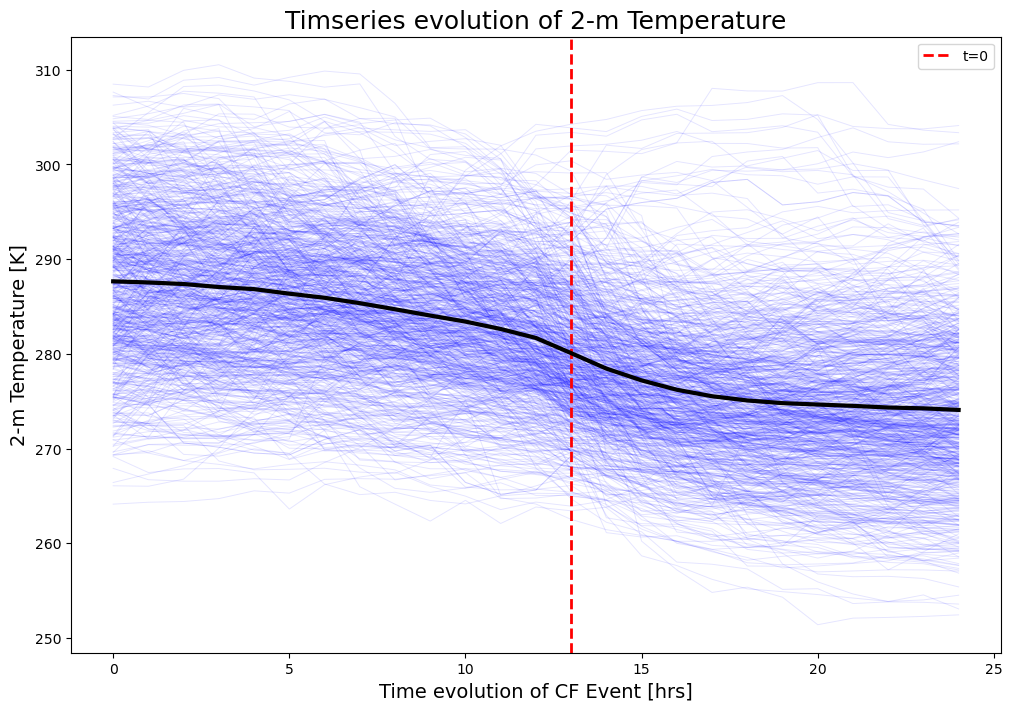

In [6]:
###Make sure the timseries are working properly along with the composite###

#Plot all the time series#
plt.figure(figsize=(12, 8))

for i in range(reshaped_data_array.shape[0]):
    
    plt.plot(reshaped_data_array.time, reshaped_data_array[i, :], color='blue', alpha=0.1, linewidth=0.7)
    
plt.xlabel('Time evolution of CF Event [hrs]', fontsize=14)
plt.ylabel('2-m Temperature [K]', fontsize=14)
plt.title('Timseries evolution of 2-m Temperature', fontsize=18)

# Add a vertical line at t=0 (index 13)
plt.axvline(x=13, color='red', linestyle='--', linewidth=2, label='t=0')
plt.legend()

#Calculate and plot the average line#
average_time_series = reshaped_data_array.mean(dim='CF_events')
plt.plot(reshaped_data_array.time, average_time_series, color='black', linewidth=3, label='Composite')